<h1>Table of Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-Prepare-Data" data-toc-modified-id="Load-and-Prepare-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and Prepare Data</a></span></li><li><span><a href="#Time-Series-Plots" data-toc-modified-id="Time-Series-Plots-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time Series Plots</a></span><ul class="toc-item"><li><span><a href="#Basic-Line-Plot" data-toc-modified-id="Basic-Line-Plot-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Basic Line Plot</a></span></li><li><span><a href="#Seasonal-Plots" data-toc-modified-id="Seasonal-Plots-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Seasonal Plots</a></span></li><li><span><a href="#Time-series-decomposition-plot" data-toc-modified-id="Time-series-decomposition-plot-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Time series decomposition plot</a></span></li><li><span><a href="#Autocorrelation-Plots" data-toc-modified-id="Autocorrelation-Plots-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Autocorrelation Plots</a></span></li></ul></li></ul></div>

In [2]:
import datetime as dt
import sys
from pathlib import Path

import codebook.EDA as EDA
import codebook.clean as clean
import numpy as np
import pandas as pd
import plotly.express as px
# import plotly.graph_objects as go  # if needed
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('raph-base')

pio.renderers.default = 'notebook' # online only
pio.templates.default = 'plotly_white'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 30)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

np.random.seed(666)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print(sys.executable)
print(sys.version)
print(f'Seaborn {sns.__version__}')

C:\Users\r2d4\miniconda3\envs\py3\python.exe
3.8.3 (default, May 19 2020, 06:50:17) [MSC v.1916 64 bit (AMD64)]
Seaborn 0.11.0


## Load and Prepare Data

In [5]:
# Load from parquet file

filename = 'turnover_data_prepared_monthly.parquet'
rel_path = 'data'

data_raw = pd.read_parquet(Path(rel_path) / filename)
data_raw["date"] = pd.to_datetime(data_raw["date"], format="%Y-%m-%d")

In [6]:
data_raw.head(5)
data_raw.info()

,date,cohort,member,value,value_pct
0,2015-01-31,2015,"44,041.00","5,448,126.50",0.48
1,2015-01-31,2016,1.00,1.00,0.00
2,2015-01-31,2017,1.00,1.00,0.00
3,2015-01-31,2018,1.00,1.00,0.00
4,2015-01-31,2019,1.00,1.00,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       497 non-null    datetime64[ns]
 1   cohort     497 non-null    object        
 2   member     497 non-null    float64       
 3   value      497 non-null    float32       
 4   value_pct  497 non-null    float32       
dtypes: datetime64[ns](1), float32(2), float64(1), object(1)
memory usage: 15.7+ KB


In [7]:
# Aggregate the different turnover cohort data to a total per month

df_total = pd.DataFrame(data_raw.groupby("date")["value"].sum())

# Check
df_total.head()

,value
date,
2015-01-31,"11,294,810.00"
2015-02-28,"9,093,064.00"
2015-03-31,"10,798,992.00"
2015-04-30,"10,195,118.00"
2015-05-31,"10,959,432.00"


## Time Series Plots

Take note of the special imports:

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Basic Line Plot

Can easily be done with pandas plotting, here I use seaborn.

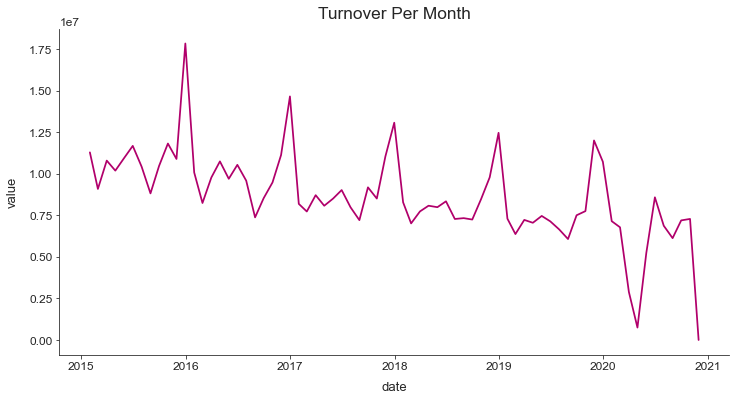

In [16]:
sns.lineplot(
    data=df_total, 
    x=df_total.index, 
    y="value"
).set_title("Turnover Per Month");

### Seasonal Plots

Note: I extract the month and year information directly from the datetime index. (Altough it would be nicer to have the months' names for the x-axis.)

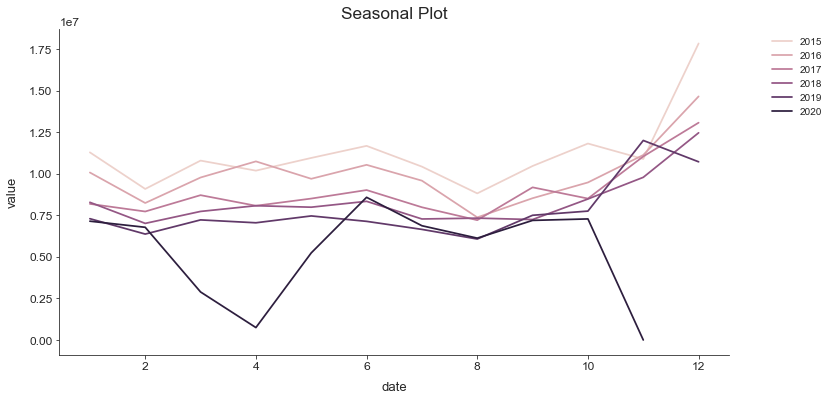

In [20]:
sns.lineplot(
    data=df_total, 
    x=df_total.index.month, 
    y="value",
    hue=df_total.index.year,
    legend="full"
).set_title("Seasonal Plot");


# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

Next is a **polar plot**, that can easily be done with Plotly. But not if the month column ("theta" param) is numeric. So I map the months integers to names first.

In [9]:
df_total["month"] = df_total.index.month
df_total["month"] = df_total["month"].map(
    {
        1: "Jan",
        2: "Feb",
        3: "Mrz",
        4: "Apr",
        5: "Mai",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Okt",
        11: "Nov",
        12: "Dez"
    }
)

px.line_polar(
    df_total, 
    r="value", 
    theta=df_total["month"], 
    color=df_total.index.year, 
    line_close=True, 
    color_discrete_sequence= ['#0d0887',  '#7201a8', '#bd3786', '#ed7953',  '#fdca26', '#f0f921'],
    title='Polar seasonal plot',
    width=600, 
    height=500
)

<img src="pics/seasonal_polar_plot.png">

### Time series decomposition plot

Decomposition assumes that a time series can be broken down into a combination of the following components:
- **level** — the average value of the series,
- **trend** — an increasing/decreasing pattern in the series,
- **seasonality** — a repeating short-term cycle in the series,
- **noise** — the random, unexplainable variation.

All time series have the level and noise components, while the trend and seasonality are optional.


There are **two main types** of decomposition models:
- **additive** — it assumes that the components above are added together (linear model). The changes over time are more or less constant.
- **multiplicative** — it assumes that the components are multiplied by each other. Hence, the changes over time are non-linear and not constant, so they can increase/decrease with time. An example could be exponential growth.

In [12]:
# Because 2020 is not yet complete and ravaged by covid, we only work with data up to 2019
df_total_short = df_total[df_total.index <= "2019-12-31"]

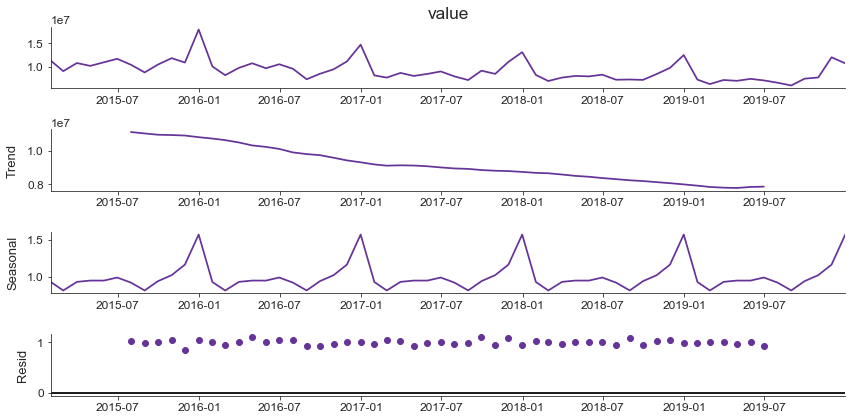

In [14]:
# Multiplicative approach

decomposition = seasonal_decompose(
    df_total_short["value"], 
    model='multiplicative', 
    period=12
)
decomposition.plot();

**Note:** The resudials for the multiplicative model should be close to 1, indicating a good fit.

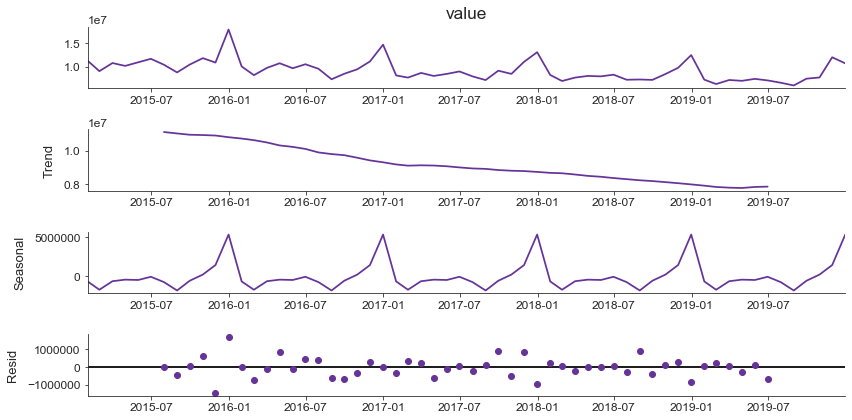

In [15]:
# Multiplicative approach

decomposition = seasonal_decompose(
    df_total_short["value"], 
    model='additive', 
    period=12
)
decomposition.plot();

**Note:** For the additive model, the residuals should be close to 0. Here we can see that the model does not fit well.

### Autocorrelation Plots

Measuring the correlation between the time series and its lagged values (from previous points in time).

There are **two types of autocorrelation plots** we can use:

- **autocorrelation function (ACF)** - shows the value of the correlation coefficient between the series and its lagged values. The ACF considers all of the components of the time series (mentioned in the decomposition part) while finding the correlations. That is why it’s known as the complete auto-correlation plot.
- **partial autocorrelation function (PACF)** - looks only at the correlation between the residuals (the remainder after removing the effects explained by the previous lags) and the following lag value. This way, we effectively remove the already found variations before we find the next correlation. In practice, a high partial correlation indicates that there is some information in the residual that can be modeled by the next lag. So we might consider keeping that lag as a feature in our model.

Normally, the autocorrelations plots are often used for determining the stationarity of the time series or choosing the hyperparameters of the ARIMA class models

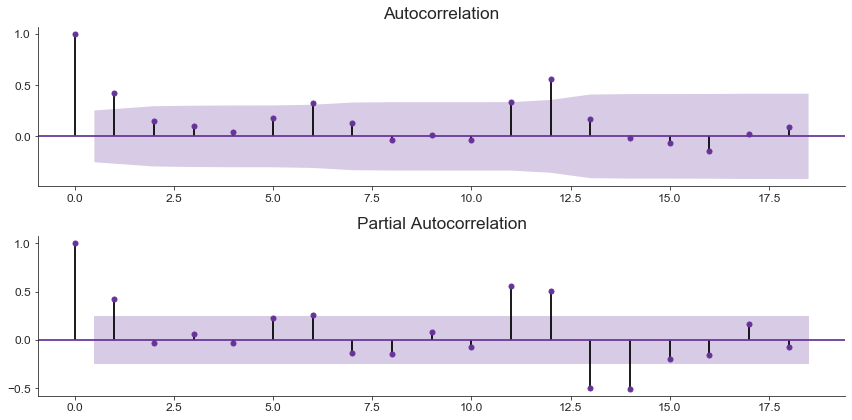

In [17]:
fig, ax = plt.subplots(2)
plot_acf(df_total_short["value"], ax=ax[0])
plot_pacf(df_total_short["value"], ax=ax[1])
plt.tight_layout();

**Note:** In the ACF plot, we can see that there are only a few significant autocorrelations (above the 95% confidence interval, corresponding to the default 5% significance level). There are also some significant autocorrelations in the PACF plot.

---